# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [2]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **2. Importation des librairies**

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet50
# from keras.applications.resnet import ResNet121
from keras.applications.resnet import ResNet152
from keras.applications.resnet_v2 import ResNet50V2
# from keras.applications.resnet_v2 import ResNet121V2
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetLarge
from keras.applications.nasnet import NASNetMobile
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

from keras.optimizers import SGD

import math
import zipfile
from PIL import Image
print("Tensorflow version: "+tf.__version__)

Tensorflow version: 2.10.1


#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [4]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [4]:
# dict = {'small':'https://nextcloud.ig.umons.ac.be/s/QP7FoyttxJgS8Cj/download/small.zip',
#         'FIRE_DATABASE_1': 'https://nextcloud.ig.umons.ac.be/s/REWbK6K4XRtoeNw/download/FIRE_DATABASE_1.zip',
#         'FIRE_DATABASE_2': 'https://nextcloud.ig.umons.ac.be/s/faKyDy7LCxfz9Xk/download/FIRE_DATABASE_2.zip',
#         'FIRE_DATABASE_3': 'https://nextcloud.ig.umons.ac.be/s/KaqzczZsXfsnMER/download/FIRE_DATABASE_3.zip',
#         'test':'https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip'}

# for key in dict: 
#     if os.path.exists('sample_data'):
#         os.removedirs('sample_data')
#     url = dict[key]
#     wget.download(url)
#     with zipfile.ZipFile(f"{key}.zip") as db: 
#         db.extractall('bases')
#     os.remove(f'{key}.zip')

#**5. Création du fichier de labels "classes.txt"**

In [5]:
with open('classes.txt', 'w') as file:
    file.write('\n'.join(['fire', 'no_fire', 'start_fire']))

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [7]:
nb_classes = 3
batch_size=4 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=5 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "bases"
input_dim=299 #@param [224,299] {type:"raw"}
dataset_name='FIRE_DATABASE_3' #@param ["small","FIRE_DATABASE_1","FIRE_DATABASE_2","FIRE_DATABASE_3"]
train_dataset = os.path.join('bases/', dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join('bases/', test_name)
classes_path = "classes.txt"
classifier = VGG16 #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [8]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement et de test**

In [9]:
def getData(batch_size):
	train_ds = tf.keras.preprocessing.image_dataset_from_directory(
		train_dataset,               # chemin vers le jeu de données
		validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
		subset="training",           # Sélection du jeu de données d'entraînement
		seed=42,                     # Initialisation du générateur aléatoire (permutations)
		image_size = (input_dim,input_dim),   # Taille des images d'entrée
		batch_size = batch_size,   # Taille du mini-batch
		label_mode= 'categorical'    # Conversion au format One-Hot
	)
	val_ds = tf.keras.preprocessing.image_dataset_from_directory(
		train_dataset,               # chemin vers le jeu de données
		validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
		subset="validation",           # Sélection du jeu de données d'entraînement
		seed=42,                     # Initialisation du générateur aléatoire (permutations)
		image_size= (input_dim,input_dim),   # Taille des images d'entrée
		batch_size= batch_size,   # Taille du mini-batch
  		label_mode= 'categorical'    # Conversion au format One-Hot
	)
	return train_ds, val_ds

def get_test(batch_size): 
	test_ds = tf.keras.preprocessing.image_dataset_from_directory(
		test_dataset,               # chemin vers le jeu de données
		seed=42,                     # Initialisation du générateur aléatoire (permutations)
		image_size= (input_dim,input_dim),   # Taille des images d'entrée
		batch_size= batch_size,   # Taille du mini-batch
	label_mode= 'categorical'    # Conversion au format One-Hot
	)
	return test_ds

'bases/FIRE_DATABASE_3'

In [10]:
os.listdir(dataset_root)

NameError: name 'dataset_root' is not defined

# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [11]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(scale=1./255),
        # keras.layers.RandomFlip("horizontal_and_vertical"),
        # keras.layers.RandomRotation(0.4),
        # keras.layers.RandomZoom(0.3)

    ]
)


def get_model(model) : 
    base_model = model(
        weights='imagenet',
        input_shape=(input_dim,input_dim,3),
        include_top=False
    )
    
    base_model.trainable = False
    inputs = keras.Input(shape=(input_dim, input_dim,3))
    x = data_augmentation(inputs),
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)
    base_model = keras.Model(inputs,outputs)
    return base_model

# **11. Geler puis dégeler les poids des premières couches**

In [ ]:
# for layer in model.layers[1].layers:
  # layer.trainable = False

# model.summary()

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [12]:
batch_size=2 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=50 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_name='FIRE_DATABASE_3' #@param ["small","FIRE_DATABASE_1","FIRE_DATABASE_2","FIRE_DATABASE_3"]
classifier = InceptionV3 
    

# **12. Entraîner le modèle**

In [13]:
train_ds, val_ds = getData(2)


Found 1500 files belonging to 3 classes.
Using 1200 files for training.
Found 1500 files belonging to 3 classes.
Using 300 files for validation.


In [14]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
train_ds, val_ds = getData(batch_size)
test_ds = get_test(batch_size)
model = get_model(classifier)
model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, epochs=epochs,batch_size=batch_size, validation_data=val_ds)

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [ ]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


#**14. Afficher des courbes d'entrainement/validation**

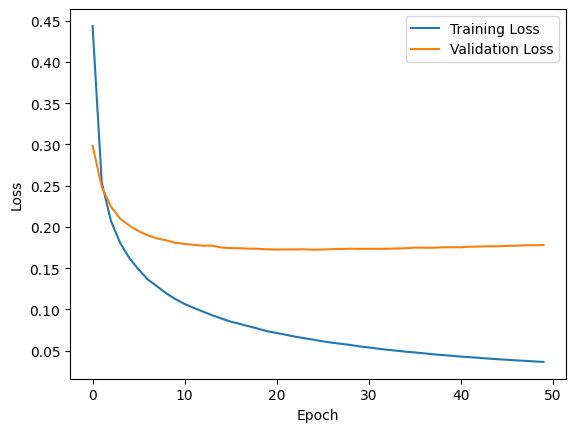

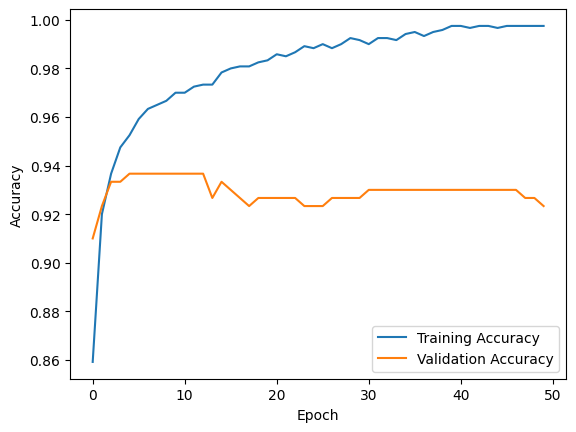

In [27]:
# Visualisation des courbes d'entraînement/validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **16. Evaluer le modèle avec ce jeu de données de test avec la fonction evaluate()**

In [28]:
eval = model.evaluate(test_ds)
print(f'Test LOSS : {eval[0]*100:.2f}%, Test Accuracy : {eval[1]*100:.2f}%')

150/150 [==============================] - 16s 99ms/step - loss: 0.3519 - accuracy: 0.8933
Test LOSS : 35.19%, Test Accuracy : 89.33%


#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [ ]:
history

1/1 [==============================] - 3s 3s/step
Class Name : fire --- Class Probability: 56.29%
Class Name : no_fire --- Class Probability: 24.90%
Class Name : start_fire --- Class Probability: 18.80%


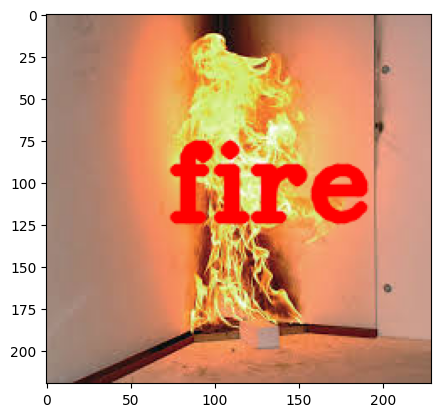

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
batch_sizes = [32,128] 
n_epochs= [5,10,20]
dataset_names = ["small","FIRE_DATABASE_1","FIRE_DATABASE_2","FIRE_DATABASE_3"]
models =  [Xception,VGG16,VGG19,ResNet50,ResNet152,InceptionV3,InceptionResNetV2,MobileNet,MobileNetV2,DenseNet121,DenseNet201,NASNetLarge,NASNetMobile] 
dict = {}


for data_name in dataset_names: 
    dict[data_name] = {}
    for base_model in models:
        model_name = base_model.__name__
        base_model = get_model(base_model)
        dict[data_name][model_name] = {}
        for batch_siz in batch_sizes:
            dict[data_name][model_name][batch_siz] = {}
            train_ds, val_ds = getData(batch_siz)
            test_ds = get_test(batch_siz)
            for n_epoch in n_epochs:
                model_cloned = keras.models.clone_model(base_model)
                model_cloned.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
                history = model_cloned.fit(train_ds, epochs=n_epoch,batch_size=batch_siz, validation_data=val_ds)
                eval = model_cloned.evaluate(test_ds)
                dict[data_name][model_name][batch_siz][n_epoch] = [history,eval]
                print(f'Model name : {model_name} batch_size :{batch_siz}')


print(dict)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 10, 2048), dtype=tf.float32, name=None), name='xception/block14_sepconv2_act/Relu:0', description="created by layer 'xception'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='global_average_pooling2d_11/Mean:0', description="created by layer 'global_average_pooling2d_11'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense_11/Softmax:0', description="created by layer 'dense_11'")
Found 1500 files belonging to 3 classes.
Using 1200 files for training.
Found 1500 files belonging to 3 classes.
Using 300 files for validation.
Found 300 files belonging to 3 classes.
Epoch 1/5
38/38 [==============================] - 76s 2s/step - loss: 1.0987 - accuracy: 0.3367 - val_loss: 1.0991 - val_accuracy: 0.3000
Epoch 2/5
38/38 [==============================] - 64s 2s/step - loss: 1.0986 - accuracy: 0.3283 - val_loss: 1.0994 - val_accuracy: 0.3000
Epoch 3/5
34/38 [===

KeyboardInterrupt: 